# Project Overview
This project is carried out on a synthetic dataset gracefully provided by Revolut. The goal of this project is to understand and address the drivers of user churn. To this end, our analysis will explore the concept of user **engagement**. We will work under the assumption that low engagement leads to user churn.

## 1. Problem Statement
In order to understand user engagement, our goal will be to:

1. Define a target metric to measure user engagement.
2. Build a model to classify engaged users.
3. Propose business actions to convert unengaged to engaged users.

## 2. Define User Engagement
We will first import the files from the data folder (we won't give detailed description of the files themselves as it is already provided in the assignemtn by Revolut).

In [495]:
import os
import datetime
import calendar

from dateutil.relativedelta import relativedelta as reldelt

import pandas as pd
import numpy as np
import scipy as sp

import category_encoders
import imblearn
import xgboost
from sklearn import model_selection
from sklearn import metrics
from sklearn import pipeline

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, clear_output

In [146]:
filepath = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

In [3]:
os.listdir(filepath)

['rev-transactions.csv',
 'rev-devices.csv',
 'rev-users.csv',
 'rev-notifications.csv']

In [4]:
trans = pd.read_csv(os.path.join(filepath, 'rev-transactions.csv'), parse_dates=['created_date'])
devices = pd.read_csv(os.path.join(filepath, 'rev-devices.csv'))
users = pd.read_csv(os.path.join(filepath, 'rev-users.csv'), parse_dates=['created_date'])
notif = pd.read_csv(os.path.join(filepath, 'rev-notifications.csv'), parse_dates=['created_date'])

## 2.1 Number Of Transactions And Users Per Month
We will start our analysis by plotting the total number of transactions and users per month.

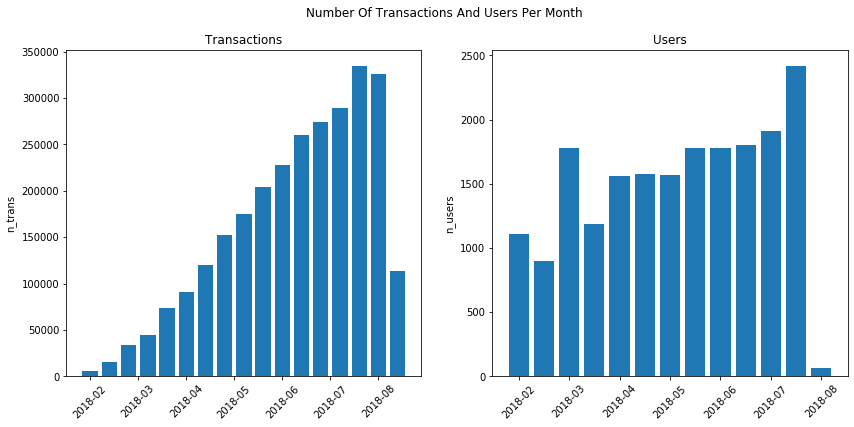

In [5]:
to_plot_1 = trans.resample('M', on='created_date').transaction_id.count()
to_plot_2 = users.resample('M', on='created_date').user_id.count()

x_ticks = {}

for df, name in zip([to_plot_1, to_plot_2],
                    ['trans', 'users']):
    x_ticks[name + '_ticks'] = list(range(len(df)))
    x_ticks[name + '_labels'] = [d.strftime('%Y-%m') for d in df.index]

fig = plt.figure(figsize=(14, 6))

fig_1 = plt.subplot(1, 2, 1)
fig_1.bar(x_ticks['trans_ticks'], to_plot_1.values)
fig_1.set_xticklabels(x_ticks['trans_labels'], rotation=45)
fig_1.set_title('Transactions')
fig_1.set_ylabel('n_trans')

fig_2 = plt.subplot(1, 2, 2)
fig_2.bar(x_ticks['users_ticks'], to_plot_2.values)
fig_2.set_xticklabels(x_ticks['users_labels'], rotation=45)
fig_2.set_title('Users')
fig_2.set_ylabel('n_users')

plt.suptitle('Number Of Transactions And Users Per Month')
plt.show()

As we can see, the number of transactions per month is increasing faster compared to the number of users. The number of users have increased by 12% (from 1560 in May, 2018 to 1912 in November, 2018), while the number of transactions in the same period has increased by 32% (from 73270 to 228287). This means that the growth in transactions is not only due to the growth in new users, but also due to the growth in the number of transactions certain users make.

## 2.2 Hypothesis - The Number Of Transactions Can Be Used To Measure Engagement
We can therefore opine that the number of transactions can be used, in some form, to measure engagement. We can consider the amount of the transactions as well. However the amount is strongly dependent on the GDP per capita of the country where the transaction originates. Therefore it cannot be used as an absolute measure of engagement.

We should also consider the case of remittances. If the Revolut platform is used for remittances, is the receiving user engaged? The `direction` of the transfer indicates whether a user is receiving remittances. This means that if a user utilises the app simply for receiving remittances, the count of transactions would still be a valid measure. There would still be a number of inbound transactions.

Only users that do not engage with the platform at all (neither paying or receiving payments) will be considered as potential churned users.

Let us summarise our hypothesis:

1. A measure of engagement can be derived (to be determined how) from the number transactions.
2. Users who mainly receive payments are still considered engaged.
3. Only users who do not create or receive transactions are considered disengaged.

Our criteria for confirming the hypothesis are:
* The measure separates the engaged from the unengaged group
* The measure has a business utility (unengaged users are truly inactive and not utilising the platform)

## 2.3 Definition
We will begin our work on the hypothesis by aggregating the number of transactions by month and by user.

In [6]:
trans_agg = trans.groupby('user_id')\
            .resample('M', on='created_date')\
            .transaction_id.count()\
            .reset_index()

In [7]:
trans_agg.rename(columns={'transaction_id': 'n_trans'}, inplace=True)

We will focus our initial investigation on users with 14 month of history. This is in order to make sure that a low number of transactions is not due to a short time on book.

In [8]:
users_months = trans_agg.user_id.value_counts()
# user_mask_months = users_months[users_months>=14].index.to_list()

Next, we will define a churned user as a `user_id` where:
> The mean number of transactions in the last **N** months is equal or less than **M**

Both `N` and `M` are hyperparameters for this exercise. This means that we could set up an experiment where we perform grid search over a reasonable range of values for both of them.

In [9]:
%%time

M = [2, 3]
N = [1, 2, 3]
user_engagement = {}

for n in N:
    for m in M:
        data = []
        for i, u in enumerate(users_months.index):
            if users_months.loc[u] >= n:
                user_data = trans_agg[trans_agg.user_id==u].sort_values('created_date')
                mean_n_trans = user_data[-n:].n_trans.sum() / n
                data.append({'user_id': u, 'mean_n_trans': mean_n_trans})
            else:
                data.append({'user_id': u, 'mean_n_trans': np.nan})

            clear_output()
            print(f'Calculated for user {i}, for N={n} and M={m}')
        user_engagement[(n, m)] = pd.DataFrame(data)
        user_engagement[(n, m)]['engaged'] = [1 if mean_n_trans > m
                                              else 0
                                              for mean_n_trans
                                              in user_engagement[(n, m)].mean_n_trans]

        user_engagement[(n, m)]['log_mean_n_trans'] = np.log1p(user_engagement[(n, m)].mean_n_trans)

Calculated for user 18765, for N=3 and M=3
CPU times: user 18min 11s, sys: 1min 3s, total: 19min 14s
Wall time: 19min 6s


In [10]:
for n in N:
    for m in M:
        engaged_count = user_engagement[(n, m)].engaged.value_counts()
        all_users = engaged_count.sum()
        unengaged = engaged_count[0]
        print('With N={} and M={}, the unengaged are {:.0%} of all users.'\
              .format(n, m, unengaged/all_users))
        del engaged_count

With N=1 and M=2, the unengaged are 27% of all users.
With N=1 and M=3, the unengaged are 35% of all users.
With N=2 and M=2, the unengaged are 20% of all users.
With N=2 and M=3, the unengaged are 25% of all users.
With N=3 and M=2, the unengaged are 25% of all users.
With N=3 and M=3, the unengaged are 29% of all users.


## 2.4 Investigate The Results And Confirm The Hypothesis
Let us investigate the difference in distribution for the log of mean number of transactions for the group labeled as engaged and the one labeled as unengaged. We will plot the results for `N` = 3 and `M` = 3, but we will perform the statistical tests for all cases from our grid search experiment.

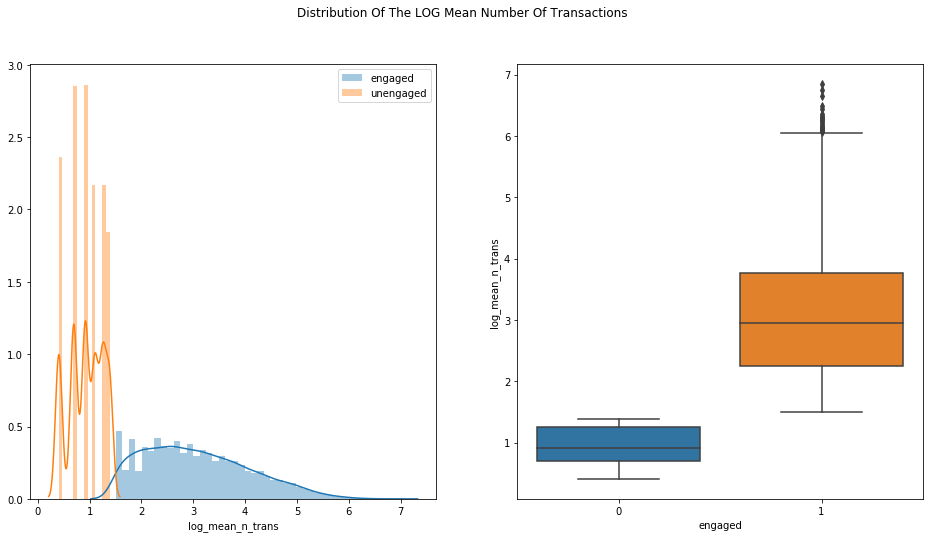

In [25]:
fig = plt.figure(figsize=(16, 8))

to_plot = user_engagement[(2, 3)]

plt.subplot(1, 2, 1)
sns.distplot(to_plot[to_plot.engaged==1].log_mean_n_trans, norm_hist=True)
sns.distplot(to_plot[to_plot.engaged==0].log_mean_n_trans, norm_hist=True)
plt.legend(labels=['engaged', 'unengaged'])

plt.subplot(1, 2, 2)
sns.boxplot(x='engaged', y='log_mean_n_trans', data=to_plot)

plt.suptitle('Distribution Of The LOG Mean Number Of Transactions')
plt.show()

As we can see, the engaged group conducts on average 100 transactions per month, while the uengaged group conducts on average 1 transaction per month (we have used a `log1p` function to avoid exiting the domain of the `log` function).

We now need to assert that the two distributions are significantly different. We can do that using a Kolmogorov-Smirnov test.

In [12]:
for n in N:
    for m in M:
        to_plot = user_engagement[(n, m)]
        ks_test = sp.stats.ks_2samp(to_plot[to_plot.engaged==1].mean_n_trans,
                                    to_plot[to_plot.engaged==0].mean_n_trans)
        print('With N={} and M={}, the KS test result is: {}.'.format(n, m, ks_test))
        del to_plot, ks_test

With N=1 and M=2, the KS test result is: Ks_2sampResult(statistic=1.0, pvalue=0.0).
With N=1 and M=3, the KS test result is: Ks_2sampResult(statistic=1.0, pvalue=0.0).
With N=2 and M=2, the KS test result is: Ks_2sampResult(statistic=0.7332793959007551, pvalue=0.0).
With N=2 and M=3, the KS test result is: Ks_2sampResult(statistic=0.7928361960620025, pvalue=0.0).
With N=3 and M=2, the KS test result is: Ks_2sampResult(statistic=0.5870124303471924, pvalue=0.0).
With N=3 and M=3, the KS test result is: Ks_2sampResult(statistic=0.5026610387227014, pvalue=0.0).


In This case, the null hypothesis is that the samples are drawn from the same distributions. As we can see from the `pvalue`, the null hypothesis is rejected (i.e. the samples represent different distributions) for every instance of the experiment.

Since all grid search results satisfy the requirements, we can allow ourselves to select the one that also fits the business needs best. In this case, having a mean number of transactions `M` = 3 spread over `N` = 2 months good be a good solution. This is because seasonal variations in business (bank holidays, vacation months) could temporary reduce the activity of some users. In this case, a longer observation period of `N` = 2 should give us a more realistic view on the consistency of a user's inactivity.

In summary, there seems to be a good separation between the categories of engaged and unengaged. The engagement metric also has business utility - engaged users have a potential to generate revenue for Revolut (if their payment plan or transaction amount are within certain parameters). On the other hand, the unengaged users have little to no chance of generating revenue.

In [126]:
n = 2
m = 3
final_labels = user_engagement[(n, m)].copy()
final_labels.set_index('user_id', drop=True, inplace=True)
trans_agg['engaged'] = [final_labels.loc[u].engaged for u in trans_agg.user_id]

Let us now go back to our very first figure where we plotted the number of transactions per month. We will now re-plot it and add the `engaged` label.

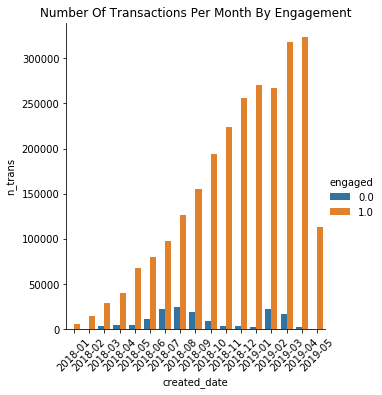

In [127]:
to_plot = trans_agg.groupby(['created_date', 'engaged']).n_trans.sum().reset_index()
x_labels = [pd.to_datetime(d).strftime('%Y-%m') for d in to_plot_1.created_date.unique()]

fig_1 = sns.catplot(x='created_date', y='n_trans', hue='engaged', data=to_plot, kind='bar')
fig_1.set_xticklabels(labels=x_labels, rotation=45)
plt.title('Number Of Transactions Per Month By Engagement')
plt.show()

As we can see, the number of transactions is increasing due to the activity of the engaged customers. This confirms our intuition and is in line with the business goals of Revolut (i.e. maximise the number of engaged customers in order to maximise revenue).

## 3. Predict User Engagement
We will now train a classifier that can predict if a customer is engaged or not. Please note that this classifier will predict the final state of the user at the end of the whole timespan of transactions less the number of months for observation (i.e. `N`). If we are to build a model for monthly prediction, we would structure the target variable differently.

That is, for monthly perdiction, we would build the target as: for every month, check if the user has on average **M** transatctions for the next **N** months. Thus we would have a set of predictions for the same users for every month of our timespan until **N** months before the latest date.

This would allow us to deploy such a model and evaluate our users every month, and take the necessary actions to prevent churn.

In our case, however, we are simply classifing the observed engaged and unengaged customers.

As this is a prototype of a model (with a limited time investment), we will consciously take several shortcuts, namely:

* We will directly use the XGBoost model. It has a proven performance advantage over other models both in terms of speed and accuracy of fit. Therefore, we will refrain from performing a grid search over several models.
* We will not perform a grid search over several feature engineering alternatives. We will select several features and model to a reasonable result of the test metrics.

We will consciously exclude the notifications as they contain items encouraging engagement and could thus lead to survivour bias. However, we can use this data for designing of measures that increase engagement.

With those clarifications in place, let us begin by selecting the latest date available in our dataset:

In [511]:
def get_m_between(date_1, date_2):
    delta = reldelt(date_1, date_2)
    return (delta.years * 12) + delta.months

def get_last_day_month(date_1, n_months):
    new_date = date_1 + reldelt(months=n_months)
    last_day = calendar.monthrange(new_date.year, new_date.month)[1]
    res_date = datetime.datetime(new_date.year, new_date.month, last_day)
    return pd.to_datetime(res_date)

In [169]:
max_trans_date = trans.created_date.max()

Our features will be based on the users table. We will select the users that have months on book > `N` such that we have valid class for the target.

The first set of features we will derive are:

* Age
* Months on book (based on the latest available date in the `transactions` dataset)
* The combination of `city` and `country`. This is an example of a feature combination as described in chapter 3.1 in [this paper](https://arxiv.org/abs/1606.07792).

In [521]:
features = users.copy()
features['age'] = [max_trans_date.year - birth_y for birth_y in features.birth_year]
features['month_on_book'] = [get_m_between(max_trans_date, d) for d in features.created_date]
features['country_city'] = features.country + '_' + features.city

In [522]:
features.drop(['birth_year', 'created_date'], axis=1, inplace=True)

Next, we will add the target variable and index the dataset on the `user_id` column.

In [523]:
features = features.merge(final_labels['engaged'], how='left', left_on='user_id', right_index=True)

In [524]:
features.set_index('user_id', drop=True, inplace=True)

In [525]:
features = features[features.engaged.notna()].copy()

We will one-hot encode the devices that each user is registered with as the next addition to the feature set.

In [526]:
device_features = pd.crosstab(devices.user_id, devices.brand)

In [527]:
features = features.join(device_features, how='left')

In [528]:
trans_agg_features = trans_agg[trans_agg.created_date < max_trans_date - reldelt(years=0, months=n)].copy()

We will also derive the total number of transactions in the last 1 month and the last 3 months (before the prediction period, that is). This is a point worth discussing in a bit more detail. If we had not limited ourselves to transactions before the perdicted period of `N` months (we will refer to it as the 'observation period'), we would have been leaking the target in the feature set. This is because the target is directly derived from the last `N` months of the transaction data.

However, we are now interested in:
* 1 month before that period
* 3 months before that period

If we were to forecast the number of transactions using a Vector Autoregressions Model, we would in essence use that same data. Therefore we consider the use of behavior data from 1 month and 3 months before the observation period as fair use in terms of modelling.

In [549]:
last_m = sorted(trans_agg_features.created_date.unique()).pop()
obs_period_start_date = pd.to_datetime(last_m)
last_1m = get_last_day_month(obs_period_start_date, -1)
last_3m = get_last_day_month(obs_period_start_date, -3)

In [530]:
for name, period in zip(['n_trans_l1_m', 'n_trans_l3_m'], [last_1m, last_3m]):
    new_feature = trans_agg_features[trans_agg_features.created_date>period].groupby('user_id').n_trans.sum().rename(name)
    features = features.join(new_feature).fillna(0)

For the notifications features, we will assume that the cases of missing values are cases of meaningful `0`.

In [531]:
for c in ['attributes_notifications_marketing_push',
          'attributes_notifications_marketing_email']:
    features[c] = features[c].fillna(0)

In [532]:
features.head()

,country,city,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals,age,month_on_book,country_city,engaged,Android,Apple,Unknown,n_trans_l1_m,n_trans_l3_m
user_id,,,,,,,,,,,,,,,,,,
user_0,PL,Gdansk,1,STANDARD,1.0,1.0,3,0,0,30,16,PL_Gdansk,1.0,0,1,0,25.0,79.0
user_1,GB,London,0,STANDARD,0.0,0.0,21,0,0,44,15,GB_London,1.0,0,1,0,0.0,28.0
user_2,PL,Poznań,0,STANDARD,0.0,0.0,21,0,0,32,15,PL_Poznań,0.0,1,0,0,1.0,5.0
user_3,FR,Paris,0,STANDARD,1.0,0.0,0,0,0,25,16,FR_Paris,0.0,0,1,0,1.0,54.0
user_4,GB,Beckenham,0,STANDARD,0.0,0.0,2,0,0,34,16,GB_Beckenham,0.0,0,1,0,0.0,2.0


As we have several categorical columns, we will use target encoding. Roughly speaking, the encoding will be a form of a ratio of the target classes based on previously-seen data.

Finally, we need to address the imbalance in the dataset. Our unengaged customers were roughly 30% of all customers. We will use a combination of oversampling of the `0` category as well as undersampling of the `1` category to achieve a balanced dataset.

In [533]:
random_seed = 42
test_size = 0.3

cat_features = ['country', 'city', 'plan', 'country_city']
cat_enc = category_encoders.target_encoder.TargetEncoder(cols=cat_features)
smt = imblearn.over_sampling.SMOTE(random_state=random_seed)

In [534]:
X, y = features.drop('engaged', axis=1), features.engaged

In [535]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_seed)

In [536]:
model = xgboost.XGBClassifier(random_state=random_seed)

In [537]:
pipe = imblearn.pipeline.Pipeline(steps=[('encode', cat_enc),
                                         ('balance', smt),
                                         ('model', model)])

With the experimentation pipeline defined as above, let us set a grid of model hyperparameters to go over. This will unfortunately be a computationally-costly exercise.

In [538]:
params = {'model__learning_rate': [.1, .01],
          'model__max_depth': [3, 5],
          'model__reg_alpha': [0, 1],
          'model__reg_lambda': [0, 1],
          'model__n_estimators': [100, 500, 1000]}

search = model_selection.GridSearchCV(pipe, params, verbose=1, n_jobs=8)

In [539]:
%%time
search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed:  6.8min finished


CPU times: user 15.5 s, sys: 801 ms, total: 16.3 s
Wall time: 7min


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('encode',
                                        TargetEncoder(cols=['country', 'city',
                                                            'plan',
                                                            'country_city'],
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      min_samples_leaf=1,
                                                      return_df=True,
                                                      smoothing=1.0,
                                                      verbose=0)),
                                       ('balance',
                                        SMOTE(k_neighbors=5, n_jobs=None,
     

Finally, we will select the best model and use the test set to produce metrics on completely-unseen data.

In [540]:
print(f'The best score from the grid search experiment is: {search.best_score_:.2f}.')

The best score from the grid search experiment is: 0.87.


In [541]:
final_model = search.best_estimator_

In [542]:
final_model

Pipeline(memory=None,
         steps=[('encode',
                 TargetEncoder(cols=['country', 'city', 'plan', 'country_city'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('balance',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=42,
                       sampling_strategy='auto')),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=500, n_jobs=1, nthread=None,
                               objective='binary:logis

In [543]:
y_pred = final_model.predict(X_test)

In [544]:
print(metrics.classification_report(y_true=y_test,
                                    y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.69      0.72      1418
         1.0       0.90      0.93      0.91      4212

    accuracy                           0.87      5630
   macro avg       0.83      0.81      0.82      5630
weighted avg       0.86      0.87      0.86      5630



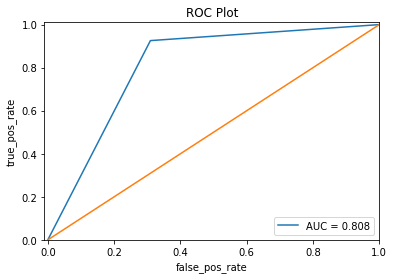

In [545]:
_false_pos, _true_pos, _thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(_false_pos, _true_pos,)

plt.plot(_false_pos, _true_pos, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1])

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])

plt.title('ROC Plot')
plt.legend(loc='lower right')
plt.ylabel('true_pos_rate')
plt.xlabel('false_pos_rate')

plt.show()

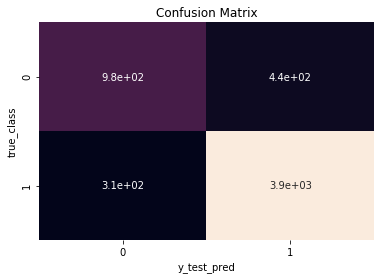

In [596]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, cbar=False)

plt.ylabel('true_class')
plt.xlabel('y_test_pred')
plt.title('Confusion Matrix')

plt.show()

In [547]:
f_importance = pd.Series(final_model.named_steps['model'].feature_importances_, index=X.columns)

In [548]:
f_importance.sort_values(ascending=False)

n_trans_l3_m                                0.244731
Apple                                       0.170443
attributes_notifications_marketing_push     0.102478
city                                        0.068333
n_trans_l1_m                                0.057721
country                                     0.053379
attributes_notifications_marketing_email    0.048092
user_settings_crypto_unlocked               0.045109
country_city                                0.042275
Unknown                                     0.037279
plan                                        0.037047
month_on_book                               0.034787
Android                                     0.031853
num_contacts                                0.018107
age                                         0.008368
num_referrals                               0.000000
num_successful_referrals                    0.000000
dtype: float32

## 4. Preventing Churn
We consciously refrained from using the `notifications` dataset during training. This is because notifications could be actions that prevent churn. This means that modelling this causal relationship could be another way of leaking the target.

In [142]:
latest_notif = notif[notif.created_date < (max_trans_date - reldelt(years=0, months=n))].copy()

In [143]:
latest_notif.head()

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808


Let us look at the mean number of engaged customers per notification category, when notification is sent 1 month before the current date:

In [593]:
notif_mask = latest_notif[(latest_notif.status=='SENT') & (latest_notif.created_date>last_1m)]
engagement_notif_l1m = notif_mask.merge(y, how='left', left_on='user_id', right_index=True)
engagement_notif_l1m.groupby('reason').engaged.mean().sort_values(ascending=False)

reason
ONBOARDING_TIPS_ACTIVATED_USERS      1.000000
PREMIUM_ENGAGEMENT_FEES_SAVED        0.958333
ENGAGEMENT_SPLIT_BILL_RESTAURANT     0.928389
MADE_MONEY_REQUEST_NOT_SPLIT_BILL    0.891566
FIFTH_PAYMENT_PROMO                  0.780306
REENGAGEMENT_ACTIVE_FUNDS            0.774714
LOST_CARD_ORDER                      0.770435
METAL_GAME_START                     0.761345
JOINING_ANNIVERSARY                  0.729502
NO_INITIAL_CARD_USE                  0.473165
Name: engaged, dtype: float64

Let us compare the results from above to notifications sent 3 months before the current date:

In [594]:
notif_mask = latest_notif[(latest_notif.status=='SENT') & (latest_notif.created_date>last_3m)]
engagement_notif_l3m = notif_mask.merge(y, how='left', left_on='user_id', right_index=True)
engagement_notif_l3m.groupby('reason').engaged.mean().sort_values(ascending=False)

reason
PREMIUM_ENGAGEMENT_FEES_SAVED           0.974684
ONBOARDING_TIPS_ACTIVATED_USERS         0.952118
ENGAGEMENT_SPLIT_BILL_RESTAURANT        0.946786
MADE_MONEY_REQUEST_NOT_SPLIT_BILL       0.909091
REENGAGEMENT_ACTIVE_FUNDS               0.797451
FIFTH_PAYMENT_PROMO                     0.791295
METAL_GAME_START                        0.761345
JOINING_ANNIVERSARY                     0.728314
LOST_CARD_ORDER                         0.709629
NO_INITIAL_CARD_ORDER                   0.638528
NO_INITIAL_CARD_USE                     0.623074
NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER    0.506667
Name: engaged, dtype: float64

It looks like the `ONBOARDING_TIPS_ACTIVATED_USERS`, `PREMIUM_ENGAGEMENT_FEES_SAVED` and `ENGAGEMENT_SPLIT_BILL_RESTAURANT` messages are related to the mean number of engaged customers. We can therefore propose the following A/B test:

We can split our predicted, unengaged customers in two groups (test group and control group). The test group will receive an engagement notification and we will measure the results `N` months after sendout. If the test group outperforms the control group (and the expected `M` transactions in `N` months), we can implement the measure for the entire population.

## 5. Improvements
Since this exercise was under a significant time constraints, we have not been able to roll out a full solution. However one such would include:

* The implementation of monthly forecasts of engagement and measuring against the test metrics for every month.
* A more detailed investigation of the actions that can nudge the customers into engagement.
* More thorough feature engineering and regressive feature elimination.
* Use of semi-supervised learning that to learn what an 'engaged' customer is and recognizing the opposite based on the error from the expectation.
* Directly forecasting the number of transactions for the next `N` months based on endogenous as well as exogenous metrics.

Thank you for the challenge!